In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical

from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_add_pool, global_max_pool
import torch.nn.functional as F
import numpy as np

from gfn import ConditionalFlowModel, ContrastiveScorer

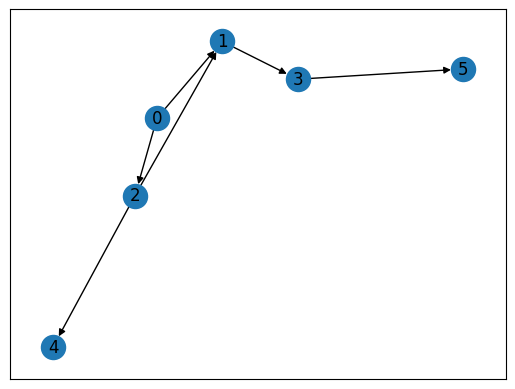

In [38]:
def is_cycle(edges, edge):
    # check if adding edge creates a cycle
    # edges is a list of edges, edge is a new edge
    # returns True if cycle is created
    if len(edges) == 0:
        return False
    edges = edges + [edge]
    num_nodes = max([max(edge) for edge in edges]) + 1
    adj = torch.zeros((num_nodes, num_nodes))
    for edge in edges:
        adj[edge[0], edge[1]] = 1
    return (torch.trace(torch.matrix_power(adj, 5*num_nodes)) > 0).item()

# generate a random DAG
def generate_dag(num_steps, num_features):
    graph_node_features = []
    graph_edge_indices = []

    for i in range(num_steps):
        node_features = torch.randn(num_features)
        
        
        if i == 0:
            graph_node_features.append(node_features)
            continue

        # generate a random edge from one of the existing nodes to either a new node or an existing node
        # if the edge creates a cycle, try again, with timeout
        k = 0
        while True:
            k += 1
            if k > 100:
                raise ValueError('Cannot generate a DAG with given parameters.')
            source = torch.randint(len(graph_node_features), (1, ))
            target = torch.randint(len(graph_node_features) + 1, (1, ))
            edge = torch.cat([source, target])
            if not is_cycle(graph_edge_indices, edge):
                # if new node, add feature
                if target == len(graph_node_features):
                    graph_node_features.append(node_features)
                graph_edge_indices.append(edge)
                break
        

    graph_node_features = torch.stack(graph_node_features)
    graph_edge_indices = torch.stack(graph_edge_indices)
    return graph_node_features, graph_edge_indices

def visualize_dag(graph_node_features, graph_edge_indices):
    # visualize the DAG
    import networkx as nx
    import matplotlib.pyplot as plt
    G = nx.DiGraph()
    for i in range(graph_node_features.shape[0]):
        G.add_node(i)
    for edge in graph_edge_indices:
        G.add_edge(edge[0].item(), edge[1].item())
    nx.draw_networkx(G, with_labels=True)
    plt.show()

graph_node_features, graph_edge_indices = generate_dag(10, 5)
visualize_dag(graph_node_features, graph_edge_indices)


In [ ]:
# test the DAG scorer
net_config = {
    'num_node_features': 5,
    'hidden_dim': 10,
    'num_heads': 2,
    'dropout': 0.1,
    'num_gat_layers': 2,
    'graph_embedding_dim': 10,
    'num_contrastive_layers': 2,
}
scorer = ContrastiveScorer(net_config)

# Random minibatch of graph pairs
graph_pairs = []
while len(graph_pairs) < 10:
    try:
        graph1_node_features, graph1_edge_indices = generate_dag(10, 5)
        graph2_node_features, graph2_edge_indices = generate_dag(10, 5)
        graph_pairs.append([graph1_node_features, graph1_edge_indices, graph2_node_features, graph2_edge_indices])
    except ValueError:
        pass

graph1s = torch.stack([graph_pair[0] for graph_pair in graph_pairs])
graph1_edge_indices = torch.stack([graph_pair[1] for graph_pair in graph_pairs])
graph2s = torch.stack([graph_pair[2] for graph_pair in graph_pairs])
graph2_edge_indices = torch.stack([graph_pair[3] for graph_pair in graph_pairs])

# test one optimization step of the scorer
# generate random pari assignments, 0 or 1
pair_assignments = torch.randint(2, (graph1s.shape[0], ))
optimizer = torch.optim.Adam(scorer.parameters(), lr=0.001)
optimizer.zero_grad()

predicted_scores = scorer(graph1s, graph1_edge_indices, graph2s, graph2_edge_indices)

loss = F.binary_cross_entropy_with_logits(predicted_scores, pair_assignments.float())
loss.backward()
optimizer.step()


    

